In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
# Abrindo o dataset
math = pd.read_csv('student-mat.csv')

In [46]:
# Informações gerais do dataset
math.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## Obtendo os valores de "mutual information"

#### Transformando as variáveis categóricas em numéricas com "Label Encoding"

In [47]:
# Obtendo lista das variáveis categóricas
catFeatures = math.select_dtypes('object').columns.to_list()
print(catFeatures)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [48]:
math[catFeatures].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


Fazendo o encoding das variáveis categóricas

Todas as variáveis são nominais. Não há ordem dentro delas. Porém, como a proposta é usar isso para obter os indíces de "mutual information", se utilizará a técnica de Label Encoding, que não cria novas colunas.

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
from sklearn.preprocessing import LabelEncoder
# Criando cópia dos dados
mathModificada = math.copy()
# Criando o LabelEncoder
label_encoder = LabelEncoder()
# Alterando as colunas categóricas
for col in catFeatures:
    mathModificada[col] = label_encoder.fit_transform(math[col])
# Conferindo o resultado
mathModificada[catFeatures].head()    

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0


In [51]:
# Duplo cheque
mathModificada.select_dtypes('object').columns.to_list()

[]

#### Antes de levantar os valores de Informação mútua se criará alguns atributos sintéticos de forma a ver também seus impactos no desempenho dos alunos

Atributos a serem criados: (1) razão entre tempo livre e tempo de estudo; (2) Razão entre tempo de saídas e tempo de estudo;(3) somatório de atributos positivos (relação familiar, nível de educação da mãe, nível de educação do pai, tempo de estudo, tempo livre, nível de saúde).

Obs: a proposta do último atributo sintético criado é somar fatores que podem, ao menos a princípio, colaborar com o desempenho dos alunos

In [52]:
# Criando o atributo razão tempo livre e tempo de estudo
mathModificada['RazaoLivreEstudo'] = mathModificada['freetime']/mathModificada['studytime']
# Criando o atributo razão tempo de saídas e tempo de estudo
mathModificada['RazaoSaidasEstudo'] = mathModificada['goout']/mathModificada['studytime']
# Criando o atributo com somatório de coisas boas
coisasBoas = ['famrel','Medu','Fedu','studytime','freetime','activities','paid']
mathModificada['Somatorio'] = mathModificada[coisasBoas].sum(axis = 1)

In [53]:
# Conferindo o atributo "Somatorio"
mathModificada[['famrel','Medu','Fedu','studytime','freetime','activities','paid','Somatorio']].head()

,famrel,Medu,Fedu,studytime,freetime,activities,paid,Somatorio
0,4,4,4,2,3,0,0,17
1,5,1,1,2,3,0,0,12
2,4,1,1,2,3,0,1,12
3,3,4,2,3,2,1,1,16
4,4,3,3,2,3,0,1,16


#### Obtendo os valores de mutual information 

Obs: Serão também utilizados os clusters gerados no notebook "Clusterização dos alunos" como atributos 

In [54]:
from sklearn.feature_selection import mutual_info_regression

In [55]:
# Carregando a tabela gerada no notebook "Clusterização dos alunos"
mathClusters = pd.read_excel('Math modificada com clusters.xlsx')
clusters = ["Cluster_estudo","Cluster_familiares","Cluster_sociais",'Cluster_geral']

# Anexando os atributos de clusteres no dataset mathModificada
mathModificada = pd.concat([mathModificada,mathClusters[clusters]],axis = 1)

In [56]:
# Separando a variável "alvo"
y = mathModificada.pop('G3')

In [57]:
# A função abaixo, primeiro, obtém os valores de mutual information e
# na sequência cria uma lista associando-os ao seu atributo.
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [58]:
mi_scores = make_mi_scores(mathModificada, y, True )

In [59]:
mi_scores

G2                    1.335924
G1                    0.812611
absences              0.114004
failures              0.098091
reason                0.066665
Cluster_geral         0.060622
Cluster_estudo        0.050958
paid                  0.048733
Somatorio             0.032971
Mjob                  0.030995
schoolsup             0.030270
nursery               0.027434
RazaoLivreEstudo      0.027094
Dalc                  0.022378
famrel                0.020660
higher                0.016516
Cluster_sociais       0.014944
goout                 0.014792
Fjob                  0.013363
sex                   0.010890
studytime             0.010170
traveltime            0.010108
Fedu                  0.009735
famsup                0.005525
Walc                  0.004934
school                0.001988
internet              0.001257
guardian              0.000000
RazaoSaidasEstudo     0.000000
romantic              0.000000
activities            0.000000
health                0.000000
Medu    

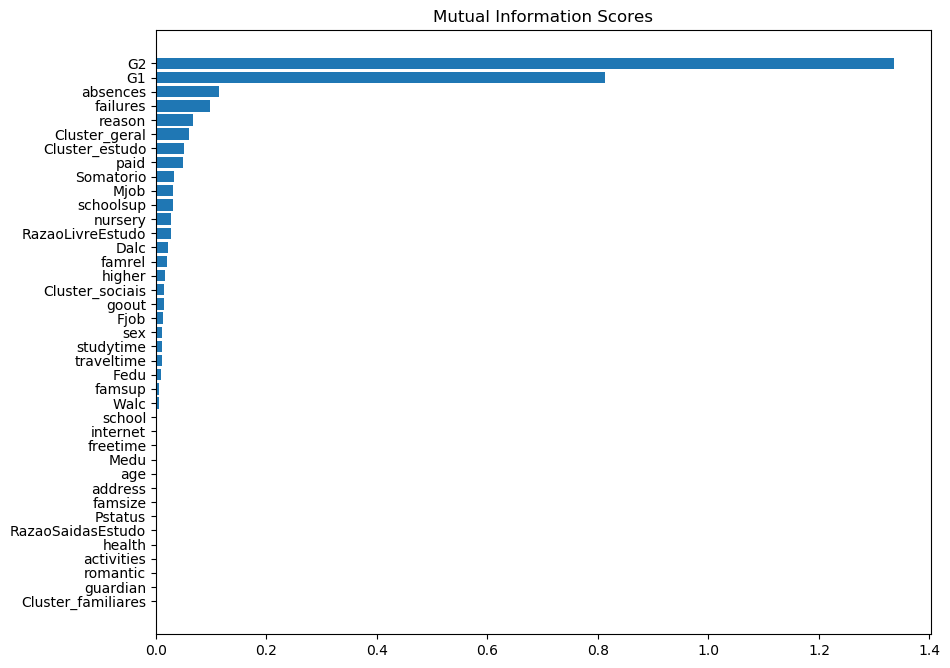

In [60]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 8))
plot_mi_scores(mi_scores)

In [61]:
# # Criando arquivo com todos atributos codificados para ser utilizado em outros notebooks
mathModificada.to_excel('Matematica - Atributos Codificados.xlsx')
# # Criando arquivo com resultados de Informação Mútua de cada atributo
mi_scores.to_excel('Matematica - Resultados de Informacao Mutua.xlsx')

## Obtendo um mapa de correlações

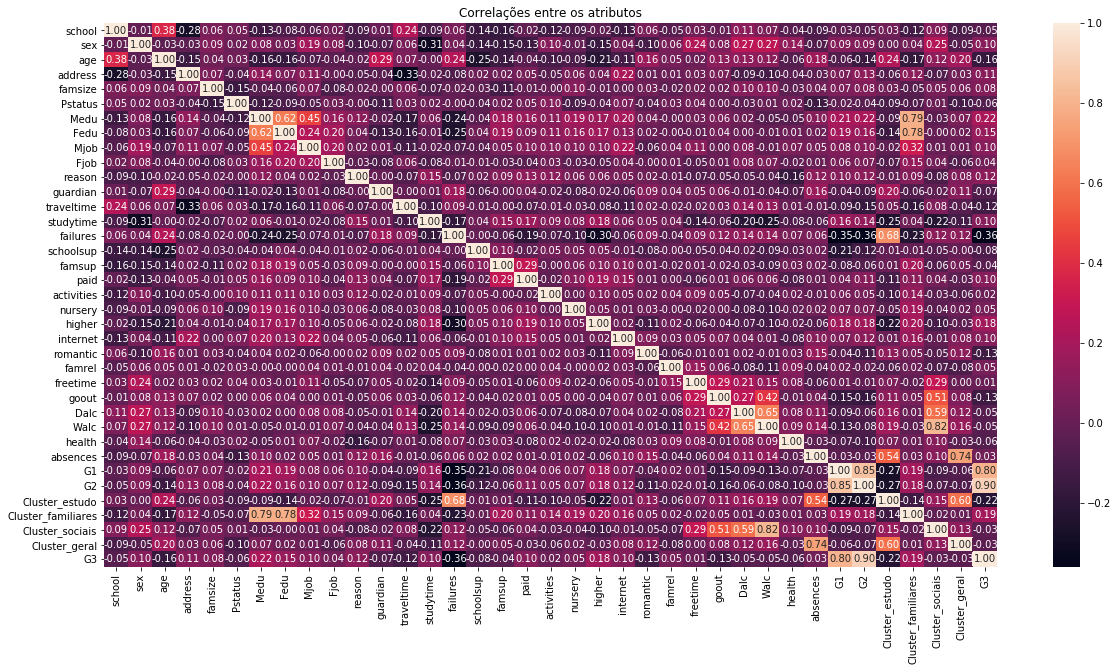

<Figure size 432x288 with 0 Axes>

In [62]:
# Eliminando os atributos sintéticos
mathModificada = mathModificada.drop(['Somatorio','RazaoLivreEstudo','RazaoSaidasEstudo'], axis = 1)
# Obtendo a matriz de correlações
mathModificada = pd.concat([mathModificada, math['G3']], axis = 1)
correlacoes = mathModificada.corr()

# Plotando a matriz
plt.figure(figsize=(20,10))
sns.heatmap(correlacoes,annot = True, fmt = ".2f")
plt.title("Correlações entre os atributos")
plt.show()

#### Fim